In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import seaborn as snb

from tqdm import tqdm
from scipy.stats import poisson
from scipy.stats import gamma

from exercise8 import compute_effective_sample_size
from exercise8 import compute_Rhat
from exercise8 import plot_summary
from exercise8 import metropolis

# style stuff
snb.set_style('darkgrid')
snb.set(font_scale=1.5)

/home/miri/anaconda3/envs/ATEL/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# 02477 Bayesian Machine Learning - Exercise 8

### Overview

Markov Chain Monte Carlo (MCMC) techniques like Metropolis-Hastings and Gibbs sampling are very powerful methods in machine learning and statistics as they provide the computational tools for sampling posterior distributions of complex non-conjugate Bayesian models.

The purpose of this exercise is to become familiar with Gibbs sampling as well as the Markov Chain Monte Carlo convergence diagnostics. First, we will study how to detect convergence in practice and how to compute the effective number of samples. Next, we will study Gibbs sampling using a simple Bayesian model for change point detection.

The exercise is divided into 3 parts:

- Part 1: The $\hat{R}$-statistic and effective sample sizes.
- Part 2: A simple model for change point detection in time series using Gibbs sampling.
- Part 3: Running the Gibbs sampler.


### Part 1: The $\hat{R}$-statistic and effective sample sizes

The purpose of the first part is to become familar with the MCMC convergence diagnostic called $\hat{R}$.  MCMC theory states that a well-designed MCMC algorithm converges asymptotically to the true target distribution, meaning that the Markov chain eventually will converge to the target distribution. The downside is that there is no strict theory for predicting when the chain will reach its stationary distribution, but there do exist heuristics that work very well in practice.

Intuitively, we can test convergence by running multiple chains in parallel starting from different initial conditions. After a given number of iterations, we can compare the chains. If the chains have reached stationarity, then they should all have the same stationary distribution. Therefore, if our chains do not have the same distributions, we can conclude the chains have not **mixed** yet.

In practice, the so-called $\hat{R}$-statistic works well for assessing convergence:

\begin{align*}
\hat{R} = \frac{N-1}{N} + \frac{1}{N}\frac{B}{W} \tag{1},
\end{align*}

where $N$ is the number of samples/iterations, $B$ is the **between-chain variance** and $W$ is the **within-chain variance**. If the between-chain variance is equal to the within-chain variance, then $\hat{R} = 1$, otherwise $\hat{R} > 1$. For most applications, the threshold $\hat{R} < 1.1$ works well for assesing convergence.

For more details, see p. 284 in Bayesian Data Analysis (http://www.stat.columbia.edu/~gelman/book/BDA3.pdf).

Another very useful statistic in MCMC is the so-called **effective sample size (ESS)** defined by

\begin{align}
S_{\text{eff}}  = \frac{S}{\sum_{t=-\infty}^{\infty} \rho_t} = \frac{S}{1 + 2\sum_{t=1}^\infty \rho_t}\tag{2},
\end{align}


where $\rho_t$ is the autocorrelation of the chains at time lag $t$. Informally, a set of $S$ MCMC samples contains less information than $S$ independent samples from the same distribution due to the correlation between MCMC samples. The effictive sample size helps us correct for this.

The provided functions `compute_Rhat` and `compute_effective_sample_size` compute $\hat{R}$ and $S_{\text{eff}}$, respectively.




Let's investigate these two statistics using a simple toy mixture distribution:

\begin{align*}
p(x) = \frac12 \mathcal{N}(x| -3, 4) + \frac12 \mathcal{N}(x|1,2) \tag{3}
\end{align*}

First, we will compute the analytical mean and variance of $p(x)$ for reference.

**Questions**

1.1) Compute the analytical mean of the distribution in eq. (3).

*Hints*:
- The expectation is a linear operator.

***Solution to 1.1***

\begin{align*}
\mathbb{E}\left[x\right] &= \int x p(x) \text{d} x\\
&= \int x \left[ \frac12 \mathcal{N}(x| -3, 4) + \frac12 \mathcal{N}(x|1,2)\right] \text{d} x\\
&=  \frac12\int x  \mathcal{N}(x| -3, 4) \text{d}x  + \frac12 \int x\mathcal{N}(x|1,2) \text{d} x\\
&= \frac12 \cdot (-3) + \frac12\cdot 1\\
&= -1
\end{align*}


1.2) Compute the analytical variance of the distribution in eq. (1)

*Hints*:
- The variance can be compute from the first and second moment: $\mathbb{V}\left[x\right] = \mathbb{E}\left[x^2\right] - \mathbb{E}\left[x\right]^2$

***Solution to 1.2***

\begin{align*}
\mathbb{E}\left[x^2\right] &= \int x^2 p(x) \text{d} x\\
&= \int x^2 \left[ \frac12 \mathcal{N}(x| -3, 4) + \frac12 \mathcal{N}(x|1,2)\right] \text{d} x\\
&= \frac12 \int x^2  \mathcal{N}(x| -3, 4) \text{d}x  + \frac12 \int x^2\mathcal{N}(x|1,2) \text{d} x\\
&= \frac12 \cdot ((-3)^2 + 4) + \frac12\cdot (1^2 + 2)\\
&= 8
\end{align*}

Therefore,

\begin{align*}
\mathbb{V}\left[x\right] = \mathbb{E}\left[x^2\right] - \mathbb{E}\left[x\right]^2 = 8 - (-1)^2 = 7
\end{align*}


Let's plot the density. Fill in the value for the true mean below.

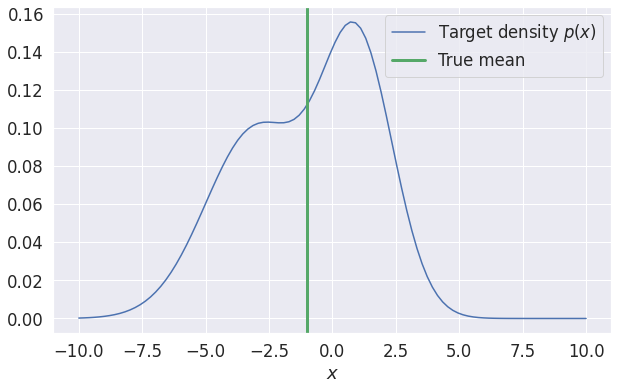

In [2]:
npdf = lambda x, m, v: np.exp(-(x-m)**2/(2*v))/np.sqrt(2*np.pi*v)

# define target from
log_target = lambda x: np.log(0.5*npdf(x, -3, 4)  + 0.5*npdf(x, 1, 2))

# we can easily compute the true mean of this target distribution using linearity
true_mean = 0.5*-3 + 0.5*1

x_space = np.linspace(-10, 10, 100)[:, None]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x_space, np.exp(log_target(x_space)), label='Target density $p(x)$')
ax.axvline(true_mean, color='g', linestyle='-', label='True mean', linewidth=3)
ax.legend()
ax.set_xlabel('$x$');



First, we will run four chains using the Metropolis-Hastings sampler from last week. See the implementation in `exercise8.metropolis`.

**Question**

1.3) Complete the implementation of the function `metropolis_multiple_chains` below such that it runs the Metropolis-Hastings sampler `num_chains` times. The function should return two arrays: 1) the samples for each chain and 2) the acceptance rate for each chain.



In [15]:
def metropolis_multiple_chains(log_joint, num_params, num_chains, tau, num_iter, x_init, warm_up=0, seed=0):
    """ Runs multiple Metropolis-Hastings chains. The i'th chain should be initialized using the i'th vector in x_init, i.e. x_init[i, :]

    Arguments:
        log_joint:          function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        num_chains:         number of MCMC chains
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (interger)
        x_init:             array of initial values (np.array with shape (num_chains, num_params))        
        warm_up:            number of warm up samples to be discarded
        seed:               seed (integer or None)
    
    returns:
        xs                  np.array of samples from each chain after warmup (shape: num_chains x (num_iter + 1 - warm_up))
        accept_rates        np.array of acceptances rate for each chain (shapes: num_chains)
    
     """

    # set seed
    np.random.seed(seed)

    # prepare arrays for storing samples
    assert len(x_init) == num_chains
    xs = np.zeros((num_chains, num_iter+1))
    accept_rates = np.zeros(num_chains)    

    # run sampler for each chain
    for idx_chain in range(num_chains):
        xs[idx_chain, :], accept_rates[idx_chain] = metropolis(log_joint, num_params, tau, num_iter, x_init=x_init[idx_chain])

    # discard warm-up samples
    xs = xs[:, warm_up:]

    return xs, accept_rates

# mcmc settings
num_chains = 4
num_iter = 1000
proposal_variance = 1.
num_params = 1
warm_up = 0
seed = 0

# generate initial values from N(0, 5)
x_init = np.random.normal(0, 5, size=(num_chains, num_params))

# sample
chains, accepts = metropolis_multiple_chains(log_target, num_params, num_chains, proposal_variance, num_iter, x_init, warm_up, seed)

# sanity check
assert chains.shape == (num_chains, num_iter+1-warm_up), f"The expected shape of chains is ({num_chains}, {num_iter+1-warm_up}) corresponding to (num_chains, num_iter+1-warm_up), but the actual shape is {chains.shape}. Check your implementation."

... and plot the results

Total number of samples:		4000
Number of effective samples:		110
Relative sample efficiency:		0.028

The true mean is:			-1.00
The estimated mean is:			-1.06
The estimated variance is:		7.28
The MCSE for the mean is:		0.26


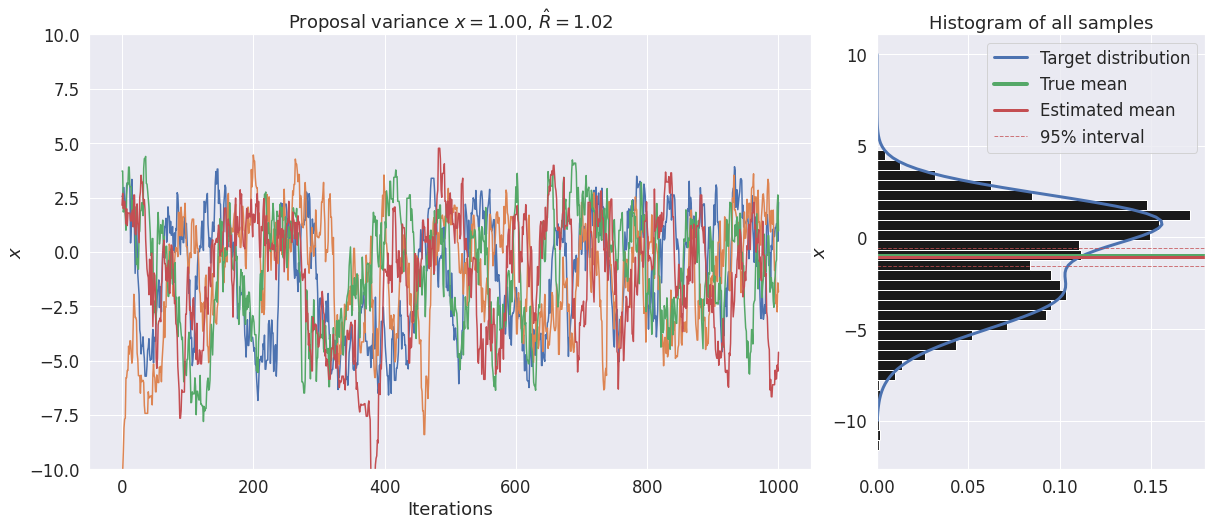

In [16]:
# compute estimate of mean and standard deviation
estimated_mean = np.mean(chains.ravel())
estimated_var = np.var(chains.ravel())
estimated_std = np.sqrt(estimated_var)

# compute \hat{R}-statistics
Rhat = compute_Rhat(chains)

# calculate total number of samples across all chains, but excluding warm-up
total_number_samples = num_chains * (num_iter - warm_up)

# calculate the number of effective samples
S_eff = compute_effective_sample_size(chains)

# calculate relative sample efficiency
R_eff = S_eff/total_number_samples

# estimate MC error
MC_error = estimated_std/np.sqrt(S_eff)

# print results
print(f'Total number of samples:\t\t{total_number_samples}')
print(f'Number of effective samples:\t\t{S_eff}')
print(f'Relative sample efficiency:\t\t{R_eff:4.3f}\n')


print(f'The true mean is:\t\t\t{true_mean:3.2f}')
print(f'The estimated mean is:\t\t\t{estimated_mean:3.2f}')
print(f'The estimated variance is:\t\t{estimated_var:3.2f}')
print(f'The MCSE for the mean is:\t\t{MC_error:3.2f}')


# visualize
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
gs = axes[0].get_gridspec()
axes[0].remove()
axes[1].remove()
ax0 = fig.add_subplot(gs[:2])
ax1 = axes[2]
ax0.plot(chains.T)
ax0.set(xlabel='Iterations', ylabel='$x$', ylim=(x_space[0], x_space[-1]), title=f'Proposal variance $x = {proposal_variance:3.2f}$, $\hat{{R}} =  {Rhat:3.2f}$')

ax1.hist(chains.flatten(), 30, density=True, orientation='horizontal', color='k');
ax1.plot(np.exp(log_target(x_space)), x_space, linewidth=3, label='Target distribution');
ax1.axhline(true_mean, color='g', linestyle='-', linewidth=4, label='True mean')
ax1.axhline(estimated_mean, color='r', linestyle='-', linewidth=3, label='Estimated mean')
ax1.axhline(estimated_mean+1.96*MC_error, color='r', linestyle='--', linewidth=1, alpha=0.75)
ax1.axhline(estimated_mean-1.96*MC_error, color='r', linestyle='--', linewidth=1, label='95% interval', alpha=0.75)
ax1.set(ylabel='$x$', title='Histogram of all samples')
ax1.legend(loc='upper right');


The code above plots the trace of the chain as well as the histogram of all the sample across all four chains. 


**Questions**

1.4) Inspect the trace plot above. Based on a visual inspection, do the chains appear to have converged? Do the $\hat{R}$-statistic agree? How well does the histogram of the MCMC samples resemble the target density?

1.5) Explain in your own words why the effective number of samples rates is often lower than actual number of MCMC samples and why it is important?

1.6) Experiment with the proposal variance - what happens to the $\hat{R}$-statistic and $S_{\text{eff}}$ when you increase the proposal variance $\tau$ to $\tau=0.5$? to $\tau=1$? to $\tau = 50$?

1.6) Explain the Monte Carlo Standard Error (MCSE) of the mean in your own words. Compare the MCSE with the difference between the estimated and true mean.

1.7) For how long do we need to run the chains to achieve a MCSE of $0.1$ or lower for $\tau=1$? What about $\tau=10$?

1.8) **Optional exercise:** Compute and plot the relative sampling efficiency (= effective number of samples divided by the total number of samples) as a function of the proposal variance in the interval from [$10^{-2}, 10^2]$. What is the optimal proposal variance for this toy distribution?

*Hint*: Use `np.logspace` to generate the values in the interval for the proposal variance.

 83%|████████▎ | 25/30 [00:04<00:00,  6.92it/s]/home/miri/anaconda3/envs/ATEL/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
100%|██████████| 30/30 [00:05<00:00,  5.54it/s]


Optimal proposal variance:  5.736
Optimal relative sample efficiency:  0.396


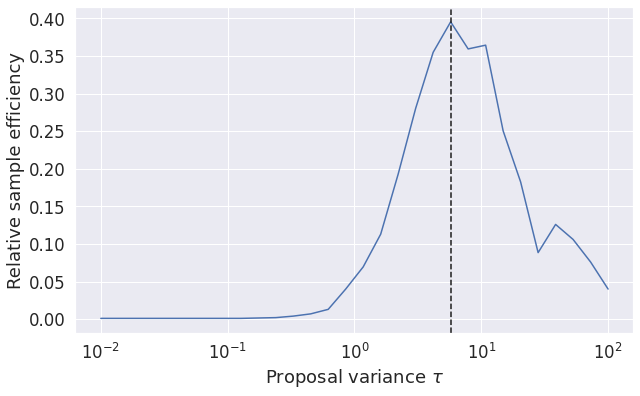

In [5]:
# Solution to 1.8

# sweep proposal variance
taus = np.logspace(-2, 2, 30)

# preallocate storage
R_effs = np.zeros(len(taus))
MCSEs = np.zeros(len(taus))

# MCMC settings
num_chains = 4
num_iter = 1000
num_params = 1
warmup = 500
seed = 123
total_number_samples = num_chains * (num_iter - warmup)

for idx_tau, tau in enumerate(tqdm(taus)):

    proposal_variance = tau
    chains, accepts = metropolis_multiple_chains(log_target, num_params, num_chains, proposal_variance, num_iter, x_init, warm_up, seed)
    R_effs[idx_tau] = compute_effective_sample_size(chains)/total_number_samples

optimal_tau = taus[np.argmax(R_effs)]
print(f'Optimal proposal variance: {optimal_tau: 4.3f}')
print(f'Optimal relative sample efficiency: {np.max(R_effs): 4.3f}')

# plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.semilogx(taus, R_effs)
ax.set(xlabel='Proposal variance $\\tau$', ylabel='Relative sample efficiency')
ax.axvline(optimal_tau, linestyle='--', color='k', label='Optimal tau');

### Part 2: A simple model for change point detection in time series using Gibbs sampling

In the first part, we will consider a simple Bayesian model for change point detection in time series. Suppose we observe a sequence of observations $\mathcal{D} = \left\lbrace x_1, x_2, \ldots, x_N \right\rbrace$ and we assume that first part of the sequence, $x_1, \ldots, x_c$, is generated by one mechanism and the rest of the time series, $x_{c+1}, \ldots, x_N$, is generated by another mechanism for $1 < c < N$. The goal of change point detection is to estimate the unknown change point $c$.

Such models are relevant in many applications, for example medical analysis (e.g. detection of sudden changes in biomedical signals), fault detection (e.g. $x_i$ could measure vibration in a wind turbine or other machinery), and fraud detection (e.g. monitoring the number of credit card transactions on websites).

In this exercise, we will use change point detection to analyze the number accidents in British coal mines from 1850 to 1965. Let's load and visualize the data:

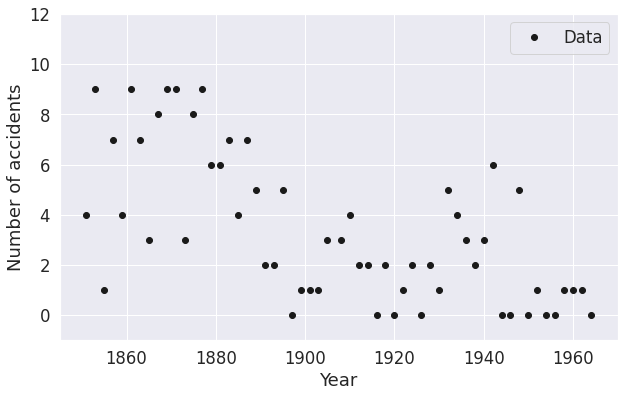

In [6]:
# load data
data = np.load('./coal_mine_data.npz')
accident_counts = data['accident_counts']
year = data['year']
N = len(year)

# plot
def plot_data(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(year, accident_counts, 'ko', label='Data')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of accidents')
    ax.legend()
    ax.set_xlim((1845, 1970))
    ax.set_ylim((-1, 12))

plot_data()

The data set consists of $N = 57$ observations, where $x_1$ denotes the number of accidents from 1850 to 1852, $x_2$ denotes the number of accidents from 1852 to 1854 etc. Thus, all observations are non-negative integers.

Let's state the model

\begin{align*}
c &\sim \mathcal{U}\left[1, N\right]\\
\lambda_1 &\sim \text{Gamma}(\alpha, \beta)\\
\lambda_2 &\sim \text{Gamma}(\alpha, \beta)\\
x_i|\lambda_1, \lambda_2, c &\sim \begin{cases}\text{Poisson}(\lambda_1) & \text{if}\quad 1 \leq i \leq c\\ \text{Poisson}(\lambda_2) & \text{if}\quad c < i \leq N \end{cases} 
\end{align*}
where $\mathcal{U}\left[1, N\right]$ represents a uniform distribution over the integers from $1$ to $N$.

That is, we assume that measurements from **before** the change point, $c$, come from a Poisson distribution with parameter $\lambda_1$ and that measurements **after** the change point come from a Poisson distribution with parameter $\lambda_2$. 

The model has three parameters: $\lambda_1, \lambda_2, $ and $c$. In order to complete the Bayesian model, we need to specify priors for all parameters. We use Gamma distributions as priors for $\lambda_1$ and $\lambda_2$ because the Gamma distribution is conjugate to the Poisson distribution. For the unknown change point $c$, we impose a uniform prior over the integers from $1$ to $N = 57$ such that $p(c) \propto 1$ for all $c$. In this exercise, we will use fixed values for $\alpha=1$ and $\beta=1$.

As usual, the posterior of interest is given by Bayes' theorem

\begin{align*}
p(\lambda_1, \lambda_2, c|\mathcal{D}) = \frac{p(x_{1:N},\lambda_1, \lambda_2, c)}{p(\mathcal{D})} =
\frac{p(x_{1:c}|\lambda_1)p(x_{{c+1}:N}|\lambda_2)p(\lambda_1)p(\lambda_2)p(c)}{p(\mathcal{D})} \propto p(x_{1:c}|\lambda_1)p(x_{{c+1}:N}|\lambda_2)p(\lambda_1)p(\lambda_2)p(c),
\end{align*}

where 

\begin{align*}
p(x_{1:c}|\lambda_1) &= \prod_{n=1}^c \text{Poisson}(x_n|\lambda_1)\\
p(x_{c+1:N}|\lambda_2) &= \prod_{n=c+1}^N \text{Poisson}(x_n|\lambda_2).
\end{align*}


Recall, the Poisson and Gamma distributions are given by

\begin{align*}
\text{Poisson}(k|\lambda) &= \frac{\lambda^k \exp(-\lambda)}{k!}\\
\text{Gamma}(\lambda|\alpha, \beta) &= \frac{1}{\Gamma(\alpha)} \beta^\alpha \lambda^{\alpha-1} \exp(-\beta\lambda),
\end{align*}

where the mean of Gamma distribution is $\mathbb{E}\left[\lambda\right] = \alpha\beta$ and the mean of a Poisson distribution is $\mathbb{E}\left[k\right] = \lambda$.

Despite the Gamma distribution being conjugate to the Poisson distribution, we cannot compute the posterior in closed-form because the model contains both $\lambda_1$ and $\lambda_2$ as well as the change point $c$. Instead, we will derive a Gibbs sampler for sampling-based inference.



## Deriving the Gibbs sampler

Next, we will derive a Gibbs sampler for the simple change point model above. Recall, that the Gibbs sampler works by iteratively generating samples from each of the three posterior conditional distributions, i.e. $p(\lambda_1|x_{1:N}, \lambda_2, c)$, $p(\lambda_2|x_{1:N}, \lambda_1, c)$, and $p(c|x_{1:N}, \lambda_1, \lambda_2)$.

First, let's write out the logarithm of the Poisson distribution:

\begin{align*}
\log \text{Poisson}(k|\lambda) &= k \log (\lambda)  -\lambda - \log (k!) \tag{4}\\
&=  k \log (\lambda)  -\lambda  + K_p, 
\end{align*}

where $K_p$ contains the term indepedent of $k$. We say the $k \log (\lambda)  -\lambda$ is the **functional form** of the Poisson distribution. This is very useful, because we know that distributions have to be normalized, which means that if encounter a distribution of the same functional form, then we know it **must** be a Poisson distribution. We will see a concrete example soon.

We can do the same for the Gamma distribution

\begin{align*}
\log \text{Gamma}(\lambda|\alpha, \beta) &= -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda)-\beta\lambda\\  
&= (\alpha-1)\log(\lambda)-\beta\lambda + K_g,    \tag{5}
\end{align*}

where $K_g$ has absorbed all terms indepedent of $\lambda$. Therefore, the **functional form** of a Gamma distribution is $(\alpha-1)\log(\lambda)-\beta\lambda$.



Now we're ready to derive the Gibbs sampler. Let's write out the log joint distribution of the model

\begin{align*}
\log p(x_{1:N},\lambda_1, \lambda_2, c) = \sum_{i=1}^c\log p(x_i|\lambda_1) + \sum_{i=c+1}^N\log p(x_{i}|\lambda_2) + \log p(\lambda_1) + \log p(\lambda_2) + \log p(c)
\end{align*}


Let's substitute in the expressions for the Poisson and Gamma distributions

\begin{align*}
\log p(x_{1:N},\lambda_1, \lambda_2, c) = &\sum_{i=1}^c \left[x_i \log (\lambda_1)  -\lambda_1 - \log (x_i!)\right] + \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2 - \log (x_i!)\right] \\
& -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda_1)-\beta\lambda_1  -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda_2)-\beta\lambda_2 + \log \frac{1}{N} \tag{6}
\end{align*}



**Deriving the posterior conditional distribution for $p(\lambda_1|x_{1:N}, \lambda_2, c)$**


Let's derive $p(\lambda_1|x_{1:N}, \lambda_2, c)$ first by collecting all the terms  in eq. (6) above that depends on $\lambda_1$. We have

\begin{align*}
\log p(\lambda_1|x_{1:N}, \lambda_2, c) &= \sum_{i=1}^c \left[ x_i \log (\lambda_1)  -\lambda_1 \right]+ (\alpha-1)\log(\lambda_1)-\beta\lambda_1 + K_1\\
&=\log (\lambda_1) \sum_{i=1}^c x_i   -c\lambda_1 + (\alpha-1)\log(\lambda_1)-\beta\lambda_1 + K_1\\
&= \left[\alpha + \sum_{i=1}^c x_i - 1\right] \log (\lambda_1)   -(\beta + c)\lambda_1 + K_1, \tag{7}
\end{align*}
where all the terms that does not depend on $\lambda_1$ have been absorped into the constant $K_1$ (constant wrt. $\lambda_1$).

If we now compare eq. (7) with eq. (5), then we notice that the functional form of eq. (7) is the same as for the Gamma distribution. By comparing the coefficients for $\log (\lambda_1)$ and $\lambda_1$, we conclude

\begin{align*}
    p(\lambda_1|x_{1:N}, \lambda_2, c) = \text{Gamma}(\lambda_1|\alpha + \sum_{i=1}^c x_i, \beta + c).
\end{align*}

The fact that this distribution turned out to be a Gamma distribution is a consequence of the Gamma distribution being conjugate to the Poisson distribution.

**Deriving the posterior conditional distribution for $p(\lambda_2|x_{1:N}, \lambda_1, c)$**


**Questions** 

Derive the posterior conditional distribution for $\lambda_2$ by following these steps:

2.1) Start by writing up all the terms in eq. (6) that depends on $\lambda_2$.


2.2) Collect all the terms that contains $\log(\lambda_2)$ and collect all the terms that contains $\lambda_2$.


2.3) Compare the result with eq. (5), verify that the functional is the same as for the gamma distribution and read of the parameters. Write down the distribution for $p(\lambda_2|x_{1:N}, \lambda_1, c)$.


**Solution**


Again, we will collect all the terms  in the eq. (6)  that depends on $\lambda_2$

\begin{align}
    \log p(\lambda_2|x_{1:N}, \lambda_1, c) &=  \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2\right]  + (\alpha-1)\log(\lambda_2)-\beta\lambda_2 + K_2\\
    &=   \left[\alpha + \sum_{i=c+1}^N x_i -1\right]\log(\lambda_2) -(\beta + N-c)\lambda_2 + K_2 \tag{8}.
\end{align}

By comparing eq. (8) to eq. (5), we again recognize the functional form of a Gamma distribution and conclude that 

\begin{align*}
    p(\lambda_2|x_{1:N}, \lambda_1, c) = \text{Gamma}(\lambda_2 |  \alpha + \sum_{i=c+1}^N x_i, \beta + N-c).
\end{align*}

**Deriving the posterior conditional distribution for $p(c|x_{1:N}, \lambda_1, \lambda_2)$**

Finally, the last piece we need to run the Gibbs samler is $p(c|x_{1:N}, \lambda_1, \lambda_2)$. Again, we follow the same recipe and collect all the terms in the eq. (6)  that depends on $c$

\begin{align}
\log p(c|x_{1:N}, \lambda_1, \lambda_2) &=  \sum_{i=1}^c \left[x_i \log (\lambda_1)  -\lambda_1 - \log (x_i!)\right] + \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2 - \log (x_i!)\right] + K_3\\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -\lambda_1 - \sum_{i=1}^c \log (x_i!)   -(N-c)\lambda_2 - \sum_{i=c}^N \log (x_i!) + K_3 \\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1    -(N-c)\lambda_2 + K'_3 \tag{9}
\end{align}

This result is not recognized as any named distribution, but that is not a problem, because recall $c \in \left\lbrace 1, 2, \dots, 57\right\rbrace$, and hence, we can obtain the full distribution $p(c|x_{1:N}, \lambda_1, \lambda_2)$ by evaluting eq. (9) for all $N = 57$ values.


### Part 3: Running the Gibbs sampler

Below you are given a template for the Gibbs sampler for the change point model.

In [7]:
def cpd_gibbs_sampler(x, alpha, beta, N, num_iter, c_init, l1_init, l2_init, warmup=0):

    # prepare arrays for store the samples
    lambda1s = np.zeros(num_iter)
    lambda2s = np.zeros(num_iter)
    cs = np.zeros(num_iter)
    
    # set initial sample
    lambda1s[0] = l1_init
    lambda2s[0] = l2_init
    cs[0] = c_init
    
    # iterate
    for k in tqdm(range(num_iter-1)):
        

        ##########################################################################
        # sample lambda 1
        ##########################################################################
        c_k = int(cs[k])        
        lambda1s[k+1] = np.random.gamma(alpha + np.sum(x[:c_k]), 1./(beta + c_k))

        ##########################################################################
        # sample lambda 2
        ##########################################################################
        lambda2s[k+1] =  np.random.gamma(alpha + np.sum(x[c_k:]), 1/(beta + N - c_k))

        
        ##########################################################################
        # sample c
        ##########################################################################
        
        # compute log probabilities for all values of c
        log_prob_c = np.zeros(N)
        for ci in range(N):
            log_prob_c[ci] = np.sum(x[:ci])*np.log(lambda1s[k+1]) - ci*lambda1s[k+1] + np.sum(x[ci:])*np.log(lambda2s[k+1]) - (N-ci)*lambda2s[k+1]

        # ... and normalize
        log_prob_c = log_prob_c - np.max(log_prob_c)
        prob_c = np.exp(log_prob_c)
        prob_c = prob_c/np.sum(prob_c)

        # finally sample new c
        cs[k+1] = np.random.choice(range(N), p=prob_c)
                
    # discard warmup samples?    
    if warmup:
        lambda1s = lambda1s[warmup:]
        lambda2s = lambda2s[warmup:]
        cs = cs[warmup:]
        
    return lambda1s, lambda2s, cs

***Questions***

3.1) What's the relationship between the Metropolis-Hastings algorithm and Gibbs sampling?

3.2) Complete the implementation of the Gibbs sampler above by filling in the details for sampling the posterior conditionals.

*Hint*: The function `np.random.gamma` is handy for sampling from a Gamma distribution.




Let's run 4 chains for 2000 iterations with 50% warmup. For later convinience, we will store the posterior samples in a dictionary.

In [8]:
# hyperparameters
alpha = 1
beta = 1

# sampler settings
np.random.seed(1234)
num_iter = 2000
num_chains = 4
warmup = int(0.5*num_iter)

l1_chains = np.zeros((num_chains, num_iter - warmup))
l2_chains = np.zeros((num_chains, num_iter - warmup))
c_chains = np.zeros((num_chains, num_iter - warmup))

for idx_chain in range(num_chains):
    
    # generate random initial values
    c_init = np.random.choice(range(N))
    l1_init = np.random.gamma(shape=alpha, scale=1/beta)
    l2_init = np.random.gamma(shape=alpha, scale=1/beta)
    
    # run sampler
    l1_chains[idx_chain, :], l2_chains[idx_chain, :], c_chains[idx_chain, :]  = cpd_gibbs_sampler(accident_counts, alpha, beta, N, num_iter, c_init, l1_init, l2_init, warmup)
    
# collect results from all chains in dictionary
gibbs_chains_dict = {'c': c_chains, 'lambda1': l1_chains, 'lambda2': l2_chains}

100%|██████████| 1999/1999 [00:02<00:00, 727.62it/s]


Let's plot the traces and histograms for all posterior parameters and check for convergence.

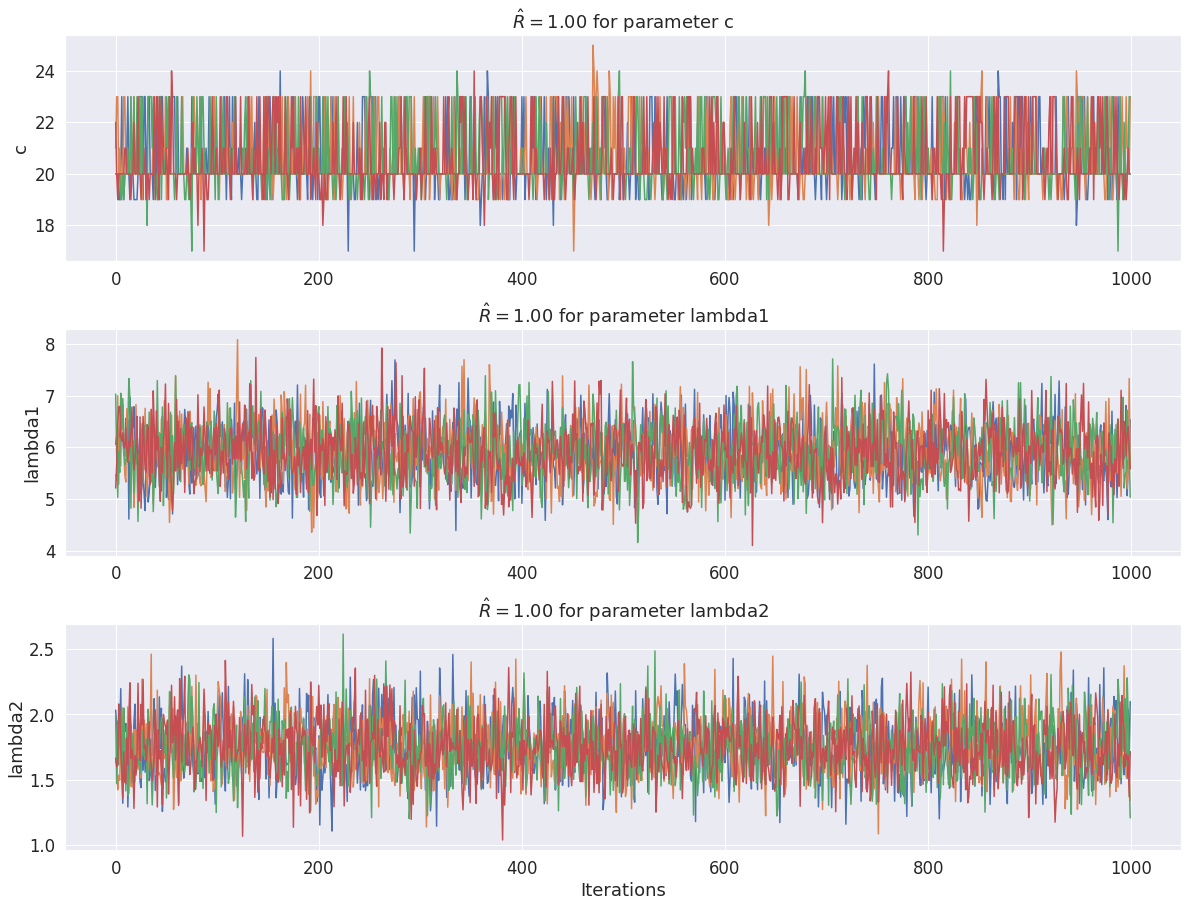

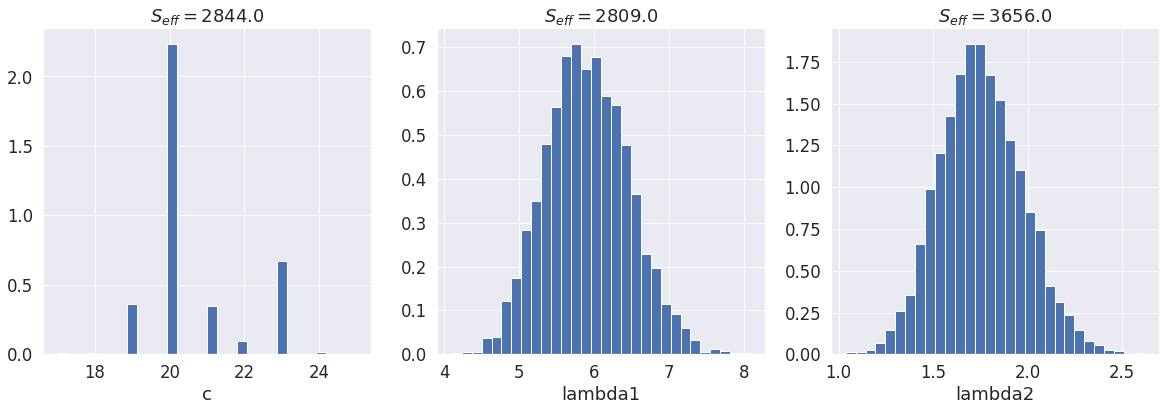

In [9]:
def plot_traces(chains_dict, name=None):
    
    # calculate Rhat diagnostic
    Rhat_dicts = {name: compute_Rhat(chains) for name, chains in chains_dict.items()}
    
    # plot
    fig, axes = plt.subplots(len(chains_dict), 1, figsize=(20, 15))
    for i, (name, chains) in enumerate(chains_dict.items()):
        for idx_chain in range(num_chains):
            axes[i].plot(chains[idx_chain])
        axes[i].set(title=f'$\hat{{R}} = {Rhat_dicts[name]:3.2f}$ for parameter {name}', ylabel=name)
        
    axes[-1].set_xlabel('Iterations')
    
    fig.subplots_adjust(hspace=0.3)
    
def plot_histograms(chains_dict):
    
    # calculate MCMC diagnostics
    Neff_dicts = {name: compute_effective_sample_size(chains) for name, chains in chains_dict.items()}
    sd_dicts = {name: np.std(chains.flatten()) for name, chains in chains_dict.items()}
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    for i, (name, chains) in enumerate(sorted(chains_dict.items())):

        axes[i].hist(chains.flatten(), 30, density=True)
        axes[i].set(title=f'$S_{{eff}}= {Neff_dicts[name]:3.1f}$', xlabel=name)
            

plot_traces(gibbs_chains_dict)
plot_histograms(gibbs_chains_dict)

**Questions**

3.3) By visual inspection of the trace plots, do the chains for all parameters appear to have converged? Does the $\hat{R}$-diagnostic agree? Do the number of $S_{\text{eff}}$ exceed $2000?$ (for later plotting purposes). If not, increase the number of iterations.



### Visualizing the posterior

No handles with labels found to put in legend.


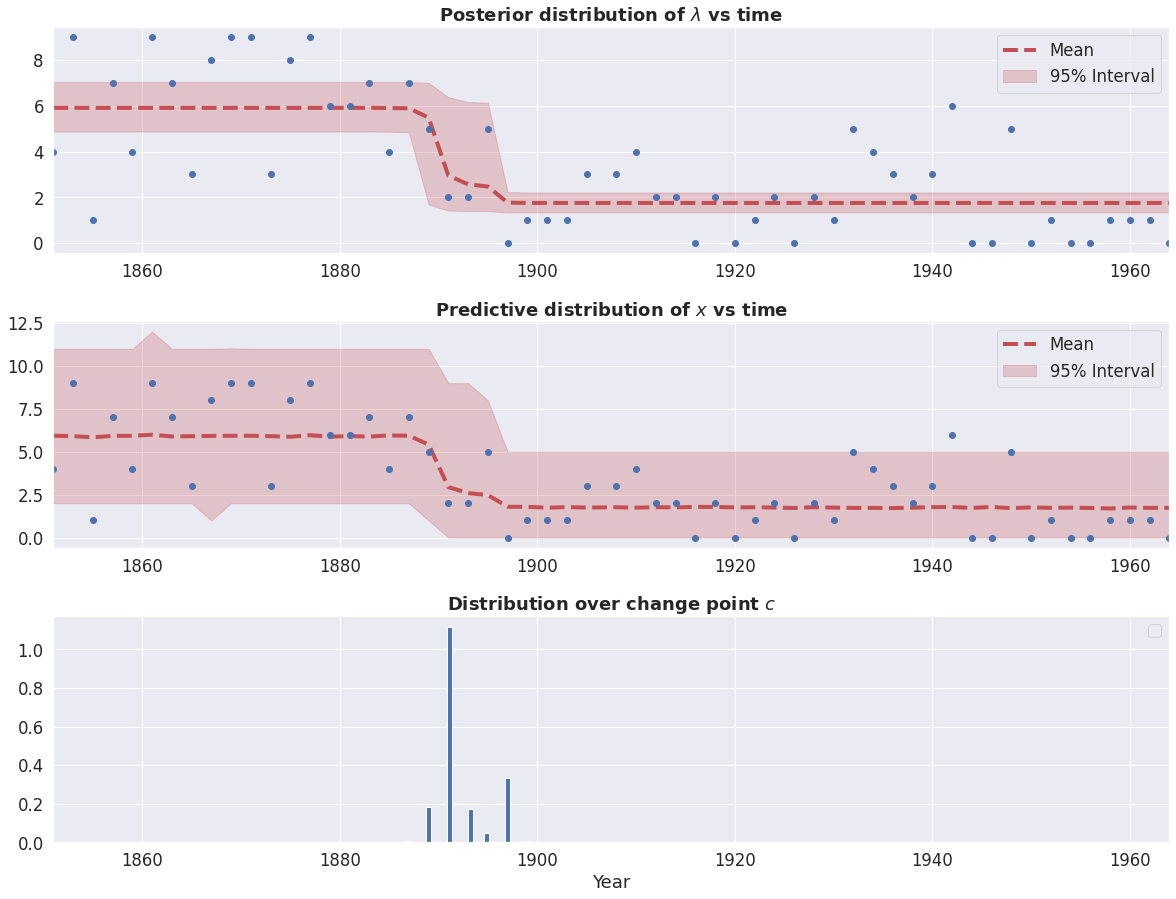

In [10]:
# grab all samples
cs = gibbs_chains_dict['c'].flatten().astype('int')
l1s = gibbs_chains_dict['lambda1'].flatten()
l2s = gibbs_chains_dict['lambda2'].flatten()

num_total_samples = len(cs)

x_samples = []
lambda_samples = []

# for each triplet of samples
for c, l1, l2 in zip(cs, l1s, l2s):
    
    xi = np.zeros((N))
    lambda_n = np.zeros((N))
    
    lambda_n[:c] = l1
    lambda_n[c:] = l2
    
    xi[:c] = np.random.poisson(l1, size=c)
    xi[c:] = np.random.poisson(l2, size=N-c)
    
    lambda_samples.append(lambda_n)
    x_samples.append(xi)
    
lambda_samples = np.array(lambda_samples)    
x_samples = np.array(x_samples)

# plot
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
plot_summary(axes[0], year, lambda_samples, num_samples=0, title='Posterior distribution of $\lambda$ vs time')
plot_summary(axes[1], year, x_samples, num_samples=0, title='Predictive distribution of $x$ vs time')

axes[2].hist(year[cs], 30, density=True);

for i in [0, 1]:
    axes[i].plot(year, accident_counts, 'bo')

for i in range(3):
    axes[i].set_xlim((min(year), max(year)))
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Year');
axes[-1].set_title('Distribution over change point $c$', fontweight='bold')


fig.subplots_adjust(hspace=0.3)

**Questions**

3.4) Inspect the plots above, explain what you see and how the plots are generated.

3.5) Compute the posterior mean and standard deviation of the for all posterior parameters, i.e. $\lambda_1$, $\lambda_2$, and $c$ (using all samples for all chains).

In [11]:
### solution to 3.5) ###
for param_name, samples in gibbs_chains_dict.items():
    print(f'{param_name}\t\tmean={np.mean(samples):3.2f}\tstd={np.std(samples):3.2f}')

c		mean=20.59	std=1.29
lambda1		mean=5.91	std=0.56
lambda2		mean=1.75	std=0.22


3.6) Compute the MCSE for the posterior mean for each parameter. Given these estimates, how many significant digits would it make sense to report for the estimate of the posterior mean?


In [12]:
### solution to 3.6) ###

for param_name, samples in gibbs_chains_dict.items():
    
    post_std = np.std(samples)
    S_eff = compute_effective_sample_size(samples)
    MCSE =  post_std/np.sqrt(S_eff)
    print(f'{param_name}\t\tMCSE of the mean = {MCSE:4.3f}')

c		MCSE of the mean = 0.024
lambda1		MCSE of the mean = 0.011
lambda2		MCSE of the mean = 0.004


3.7) Compute the posterior probability $P(c < 20|x)$, i.e  that the change point $c$ is strictly smaller than $20$.

In [13]:
### solution to 3.7) ###
prob = np.mean(gibbs_chains_dict['c'].flatten() < 20)
print('P(c < 20|x):\t\t%3.2f' % prob)

P(c < 20|x):		0.10


3.8) Compute the posterior probability for $\lambda_1$ being more than 3 times larger than $\lambda_2$.



In [14]:
### solution to 3.8 ###
I = gibbs_chains_dict['lambda1'] > 3*gibbs_chains_dict['lambda2']
print(f'Posterior probability of lambda1 > 3*lambda2: {np.mean(I):4.3f}')

Posterior probability of lambda1 > 3*lambda2: 0.782
